In [1]:
import pandas as pd
import yfinance as yf
import riskfolio as rp
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('passed.txt') as f:
    tickers = f.read().splitlines()
tickers.append('^TNX')  # 10 year treasury yield

In [3]:
# For experiment only
tickers = tickers[:10] + ['^TNX']

In [4]:
def download_data_and_calc_returns(tickers, period='5y', interval='1d', prepost=False):
    if isinstance(tickers, list):
        data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
        data = data.loc[:,('Adj Close', slice(None))]  # get adjusted close only
        data.columns = tickers
        data = data[tickers].pct_change().dropna()
        return data
    else:
        data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
        data = data.loc[:, 'Adj Close']
        data = data.pct_change().dropna()
        return data

returns = download_data_and_calc_returns(tickers)
returns.index = returns.index.map(lambda a: pd.to_datetime(a).date())  # remove timezone awareness by converting to dates only
returns = returns.sum(level=0)  # merge 2 days into 1 since different market has diff closing time

[*********************100%***********************]  11 of 11 completed


In [5]:
nasdaq_returns = download_data_and_calc_returns('^IXIC', period='10y')
nasdaq_slpm = rp.RiskFunctions.LPM(nasdaq_returns, MAR=0.04/252, p=2)

[*********************100%***********************]  1 of 1 completed


In [6]:
port = rp.Portfolio(returns=returns, sht=False, lowerret=pow(1.5, 1/(252*5))-1, upperslpm=nasdaq_slpm)

In [7]:
method_to_estimate_expected_return = 'ewma1'
method_to_estimate_covariance = 'ewma1'
port.assets_stats(method_mu=method_to_estimate_expected_return, method_cov=method_to_estimate_covariance, d=0.96)  # lower d means place more emphasis on recent performance, 0 <= d < 1

In [8]:
model = 'Classic'  # based on history
risk_measure = 'SLPM'  # Sortino Ratio
obj = 'MaxRet'
risk_free_rate = 0.04/252  # 4% annually converted to daily
w = port.optimization(model=model, rm=risk_measure, obj=obj, rf=risk_free_rate)

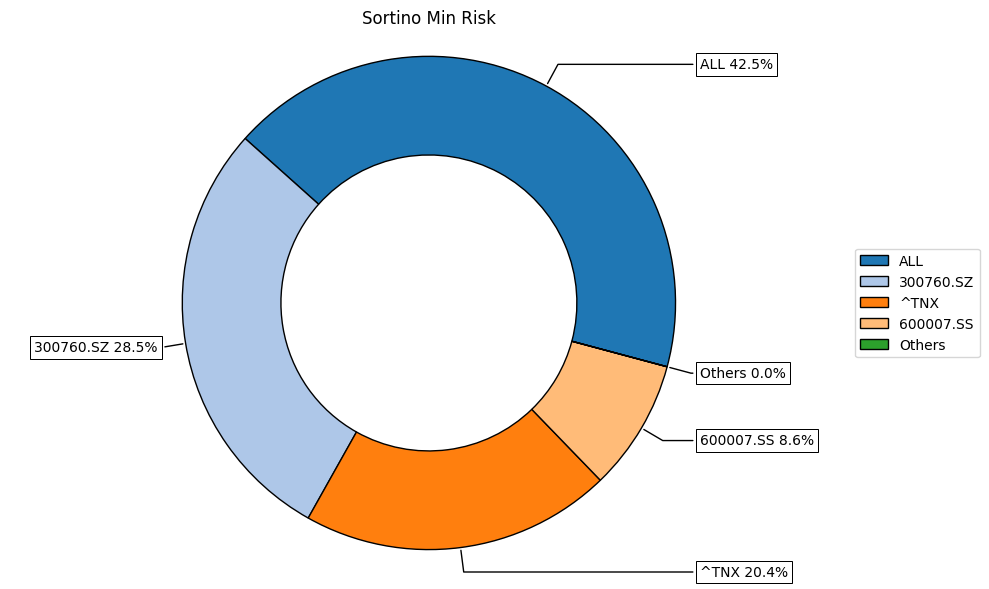

In [9]:
ax = rp.plot_pie(w=w, title='Sortino Min Risk', others=0.05, nrow=len(port.assetslist), cmap = "tab20", height=6, width=10, ax=None)

In [10]:
%%time
points = 50 # Number of points of the frontier
frontier = port.efficient_frontier(model=model, rm=risk_measure, points=points, rf=risk_free_rate)

CPU times: total: 3.39 s
Wall time: 3.41 s


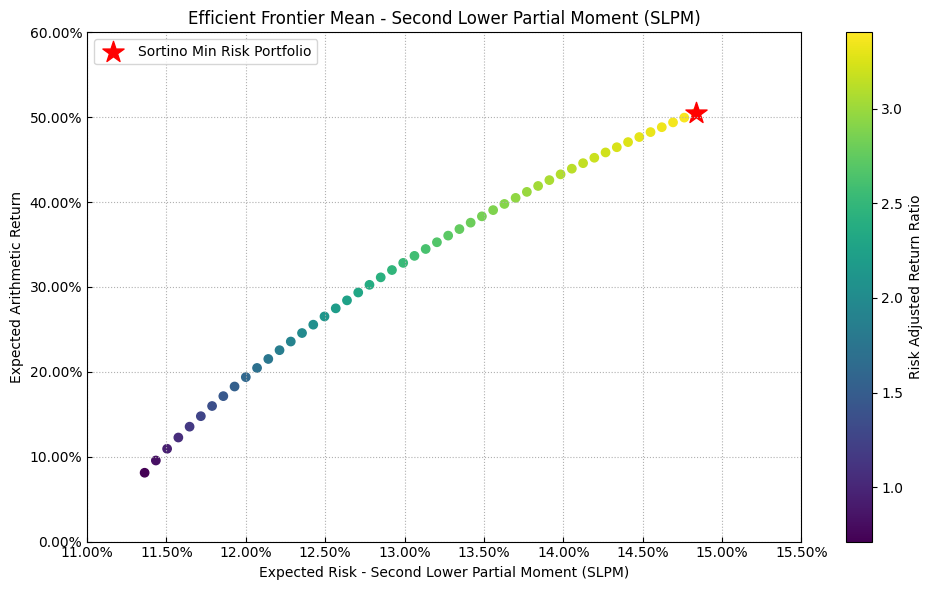

In [11]:
# Plotting the efficient frontier
label = 'Sortino Min Risk Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=risk_measure, alpha=0.05, cmap='viridis', rf=risk_free_rate, w=w, label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

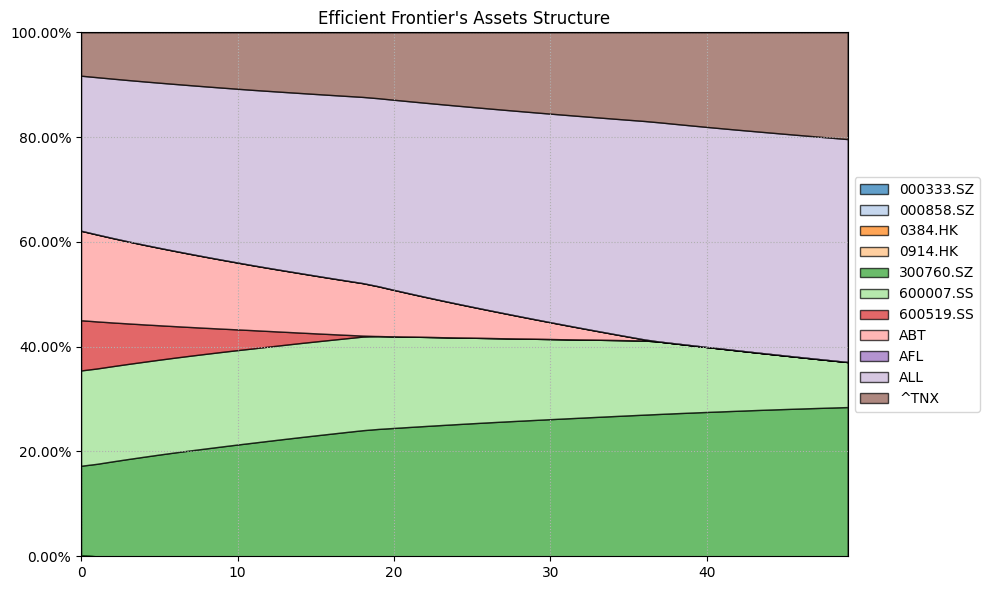

In [12]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

array([<AxesSubplot: title={'center': 'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot: title={'center': 'Portfolio Composition'}>,
       <AxesSubplot: title={'center': 'Risk (Second Lower Partial Moment) Contribution per Asset'}>,
       <AxesSubplot: title={'center': 'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

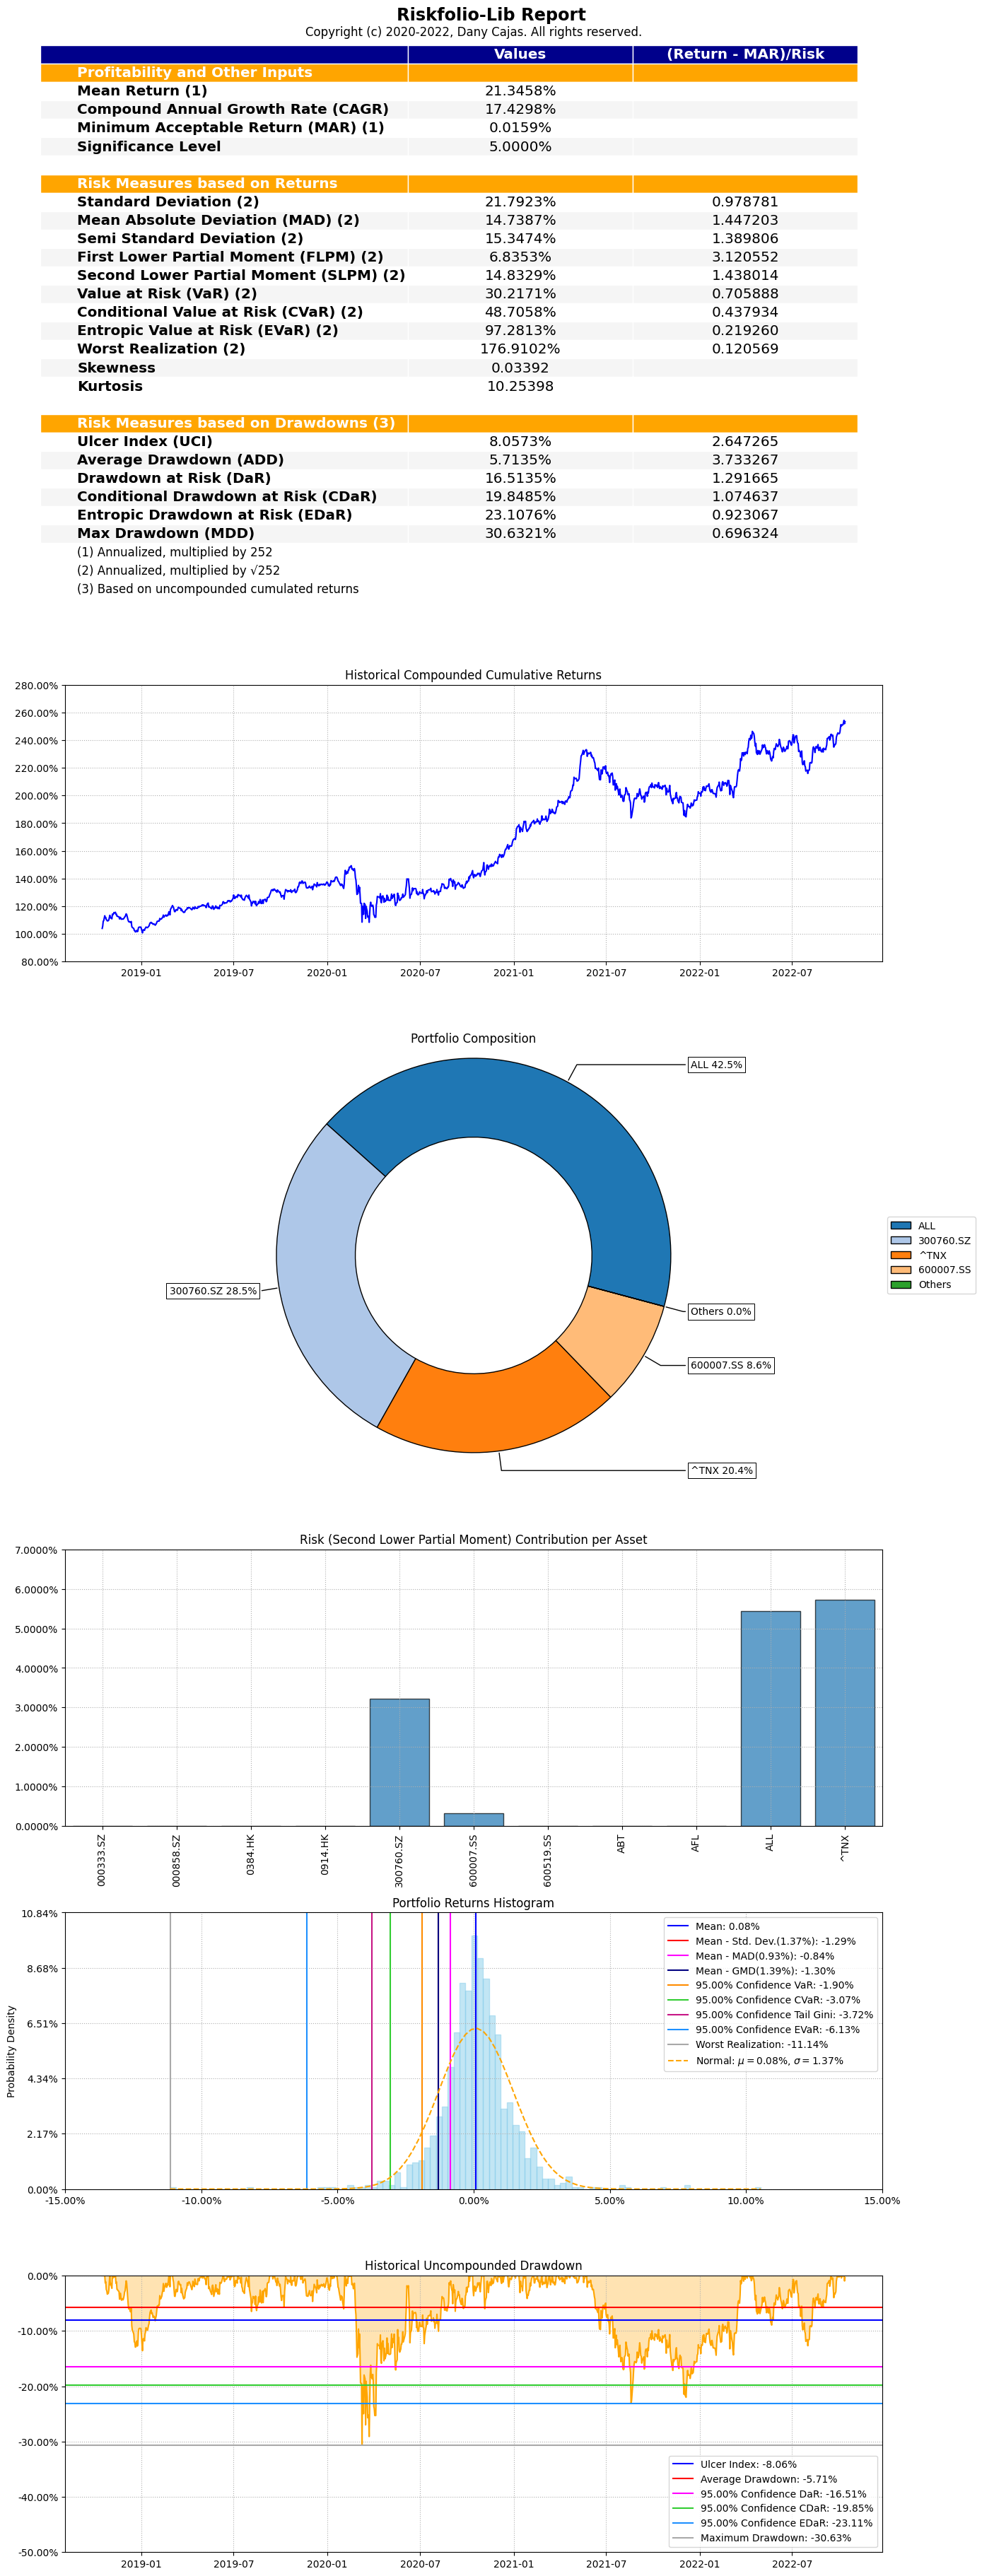

In [13]:
returns.index = returns.index.map(lambda a: pd.to_datetime(a).date())  # remove timezone awareness by converting to dates only
rp.Reports.excel_report(returns, w, rf=risk_free_rate, alpha=0.05, t_factor=252, ini_days=1, days_per_year=252, name='portfolio_report')
rp.Reports.jupyter_report(returns, w, rm=risk_measure, rf=risk_free_rate, alpha=0.05, others=0.05, nrow=len(port.assetslist), height=6, width=14, t_factor=252, ini_days=1, days_per_year=252, bins=100)